# TRACO reference solution

In [1]:
import cv2
import numpy as np
from pathlib import Path
import os
import json
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Reshape, GlobalAveragePooling2D, UpSampling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from segmentation_models.metrics import iou_score
from segmentation_models.losses import dice_loss

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

2023-04-24 20:40:20.101937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 20:40:20.254057: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 20:40:20.807873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/du92wufe/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-24 20:40:20.

Segmentation Models: using `keras` framework.


In [2]:
# Define path where the training data is located
path_training_vids = Path("training")

# Downsample the input frames to a fixed target_shape
target_shape = (256, 256)

In [3]:
def load_train_videos(path):
    """
    This function returns all trainings videos and the annotations as binary masks (1 at the positions where a Hexbug is located).
    All frames are resized and normalized. 
    """
    X = []
    Y = []
    
    for vid in os.listdir(path):
        path = Path(path)
        if ".mp4" in vid:
            with open(path / vid.replace("mp4", "traco")) as f:
                annotations = json.load(f)['rois']
            
            cap = cv2.VideoCapture(str(path / vid))
            ret, frame = cap.read()     
            org_shape = frame.shape
            
            z = 0  # frame counter
            while ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mask_frame = np.zeros(shape=target_shape)
                for annot in annotations:
                    if annot['z'] == z: 
                        # Get pos and scale it down to fit the target_shape
                        pos = annot['pos']
                        pos[0] = pos[0] * target_shape[0] // org_shape[1]
                        pos[1] = pos[1] * target_shape[1] // org_shape[0]
                        
                        # Set the position if the Hexbug in the binary mask to 1
                        try:
                            mask_frame[int(pos[1]), int(pos[0])] = 1
                        except:
                            # IndexOutOfRange error sometimes occurs because of the downsampling of the frames
                            mask_frame[int(pos[1]) - 1, int(pos[0]) - 1] = 1
                        
                # Resize the frame to the target size using bilinear interpolation
                resized_frame = cv2.resize(frame, target_shape, interpolation=cv2.INTER_LINEAR)
                
                # Normalize to zero mean and unit variance
                normalized_frame = (resized_frame.astype('float32') / 255.0 - 0.5) / 0.5
                
                # Append to lists
                X.append(normalized_frame)
                Y.append(mask_frame) 
                
                ret, frame = cap.read()  # read next frame
                z += 1  # increase frame counter
                
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

## Create and train U-Net

In [4]:
def conv_block(x, num_filters):
    x = Conv2D(filters=num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def build_Unet(filters=16, num_classes=1):
    # Input layer
    inputs = Input(shape=(target_shape[0], target_shape[1], 3))
    
    # Encoder
    e1 = conv_block(inputs, filters)
    p1 = MaxPool2D((2, 2))(e1)
    
    e2 = conv_block(p1, filters * 2)
    p2 = MaxPool2D((2, 2))(e2)
    
    e3 = conv_block(p2, filters * 4)
    p3 = MaxPool2D((2, 2))(e3)
    
    e4 = conv_block(p3, filters * 8)
    p4 = MaxPool2D((2, 2))(e4)
    
    # Bottleneck
    b1 = conv_block(p4, filters * 16)
    
    # Decoder
    d1 = UpSampling2D()(b1)
    d1 = Concatenate()([d1, e4])
    d1 = conv_block(d1, filters * 8)
    
    d2 = UpSampling2D()(d1)
    d2 = Concatenate()([d2, e3])
    d2 = conv_block(d2, filters * 4)
    
    d3 = UpSampling2D()(d2)
    d3 = Concatenate()([d3, e2])
    d3 = conv_block(d3, filters * 2)
    
    d4 = UpSampling2D()(d3)
    d4 = Concatenate()([d4, e1])
    d4 = conv_block(d4, filters)
    
    # Output layer
    outputs = Conv2D(filters=num_classes,
                     kernel_size=1,
                     padding='same',
                     activation='sigmoid')(d4)
    
    return Model(inputs, outputs)

In [5]:
# Build model
model = build_Unet(filters=32)  # original U-Net: 64 filters

# Compiling the model
model.compile(optimizer=Adam(learning_rate=1e-3),  # Define optimizer and learning rate
              loss=dice_loss,                      # Dice loss function
              metrics=[iou_score])     # Intersection over Union (IoU) & Dice score

2023-04-24 20:40:27.174920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 20:40:27.184206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 20:40:27.185112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 20:40:27.186205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [6]:
def exp_scheduler(epoch, lr):
    """
    Learning rate scheduler.
    """
    if epoch < 20:
        return 1e-3
    elif epoch < 40:
        return 1e-4
    elif epoch < 60:
        return 1e-5
    else:
        return lr * np.exp(-0.1)

In [7]:
# Load training data
X_train, Y_train = load_train_videos(path_training_vids)

In [8]:
history = model.fit(x=X_train, y=Y_train, epochs=80,
                    callbacks=[LearningRateScheduler(schedule=exp_scheduler, verbose=0)], 
                    validation_split=0.1)

Epoch 1/80


2023-04-24 20:40:58.680383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-04-24 20:40:59.361282: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-24 20:41:01.639245: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2ec67d7b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 20:41:01.639265: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-04-24 20:41:01.641928: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-24 20:41:01.683651: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-24 20:41:01.719440: I tensorflow/compiler/jit/xla_compilation_cach

283/284 [============================>.] - ETA: 0s - loss: 0.9863 - iou_score: 0.0070

2023-04-24 20:42:12.368003: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-24 20:42:12.368023: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


284/284 [==============================] - ETA: 0s - loss: 0.9862 - iou_score: 0.0070

2023-04-24 20:42:18.631117: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-24 20:42:18.631136: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


284/284 [==============================] - 83s 253ms/step - loss: 0.9862 - iou_score: 0.0070 - val_loss: 0.9927 - val_iou_score: 0.0040 - lr: 0.0010
Epoch 2/80
284/284 [==============================] - 68s 241ms/step - loss: 0.9246 - iou_score: 0.0394 - val_loss: 0.9536 - val_iou_score: 0.0247 - lr: 0.0010
Epoch 3/80
284/284 [==============================] - 69s 242ms/step - loss: 0.9036 - iou_score: 0.0509 - val_loss: 0.9391 - val_iou_score: 0.0328 - lr: 0.0010
Epoch 4/80
284/284 [==============================] - 69s 243ms/step - loss: 0.8953 - iou_score: 0.0555 - val_loss: 0.9335 - val_iou_score: 0.0359 - lr: 0.0010
Epoch 5/80
284/284 [==============================] - 69s 243ms/step - loss: 0.8872 - iou_score: 0.0601 - val_loss: 0.9494 - val_iou_score: 0.0264 - lr: 0.0010
Epoch 6/80
284/284 [==============================] - 69s 243ms/step - loss: 0.8914 - iou_score: 0.0579 - val_loss: 0.9136 - val_iou_score: 0.0468 - lr: 0.0010
Epoch 7/80
284/284 [==============================]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



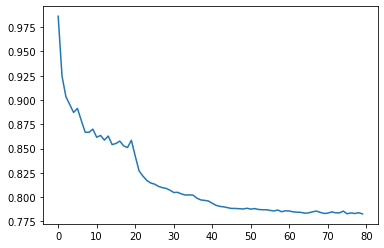

In [10]:
plt.plot(history.history['loss'])

In [ ]:
model.save("reference_")

## Apply the model to our test data

In [12]:
def load_validation_data(path):
    """
    This function returns all validation videos and the annotations as binary masks (1 at the positions where a Hexbug is located).
    All frames are resized and normalized. 
    """
    X = []
    org_shapes = []
    file_names = []
    
    for vid in os.listdir(path):
        path = Path(path)
        if ".mp4" in vid:
            with open(path / vid.replace("mp4", "traco")) as f:
                annotations = json.load(f)['rois']
                  
            cap = cv2.VideoCapture(str(path / vid))
            ret, frame = cap.read()     
            org_shape = frame.shape
            
            file_names.append(path / vid.replace("mp4", "traco"))
            org_shapes.append(org_shape)
            
            X_ = []
            while ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        
                # Resize the frame to the target size using bilinear interpolation
                resized_frame = cv2.resize(frame, target_shape, interpolation=cv2.INTER_LINEAR)
                
                # Normalize to zero mean and unit variance
                normalized_frame = (resized_frame.astype('float32') / 255.0 - 0.5) / 0.5
                
                # Append to lists
                X_.append(normalized_frame)
                
                ret, frame = cap.read()  # read next frame
            
            X.append(np.asarray(X_))           
    
    return X, org_shapes, file_names

In [16]:
X_test, org_shapes_test, file_names_test = load_validation_data("leaderboard_data")

In [24]:
def get_final_points_from_predictions(pred, org_shape):
    """
    This function finds cluster where a Hexbug is detected. It resizes the found positions back to fit the original frame shape.
    """
    points = np.transpose(np.where(pred > 0.01))
    if len(points) == 0:
        return []
    
    # Perform clustering
    eps = 10
    min_samples = 1
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(points)
    labels = dbscan.labels_
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    final_points = []
    for i in range(n_clusters):
        random_point = np.random.choice(np.where(labels == i)[0])
        random_point = points[random_point]
        random_point[0] = int(random_point[0] * org_shape[0] // target_shape[0])
        random_point[1] = int(random_point[1] * org_shape[1] // target_shape[1])
    
        final_points.append(random_point)
    
    return final_points[0:5]

In [25]:
file_names_test

[PosixPath('leaderboard_data/test0005.traco'),
 PosixPath('leaderboard_data/test0003.traco'),
 PosixPath('leaderboard_data/test0001.traco'),
 PosixPath('leaderboard_data/test0002.traco'),
 PosixPath('leaderboard_data/test0004.traco')]

In [27]:
from export_tool import traco_to_csv, from_array_to_dict, save_list

In [32]:
for idx, x in enumerate(X_test):    
    # Predict all frames of one video
    preds = model.predict(x)
    
    org_shape = org_shapes_test[idx]
    file_name = file_names_test[idx]
    
    # Get final predicted points for each frame
    n_hexbugs = None
    previous_coords = None
    results = []
    for frame_idx, pred in enumerate(preds):
        pred = np.squeeze(pred)
        coords = get_final_points_from_predictions(pred, org_shape)
        
        if n_hexbugs is None:
            n_hexbugs = len(coords)
            if n_hexbugs == 0:
                n_hexbugs = 1

        for i in range(n_hexbugs):
            try:
                results = from_array_to_dict([frame_idx, i, coords[i][1], coords[i][0]], results)
            except:
                results = from_array_to_dict([frame_idx, i, 0, 0], results)
            
    save_list(results, str(file_name).replace(".traco", ".csv"))

4/4 [==============================] - 0s 61ms/step
Saving to csv
Done
4/4 [==============================] - 0s 61ms/step
Saving to csv
Done
4/4 [==============================] - 0s 61ms/step
Saving to csv
Done
4/4 [==============================] - 0s 61ms/step
Saving to csv
Done
4/4 [==============================] - 0s 61ms/step
Saving to csv
Done
